### **1. Load Dataset**

In [54]:
import pandas as pd

train_dataset = pd.read_csv("data/train_data.csv")

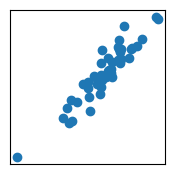

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2, 2))
plt.scatter(train_dataset["x"], train_dataset["y"])
plt.xticks([])
plt.yticks([])
plt.show()

### **2. Build Training Graph**

In [56]:
# set seed for reproducibility
import numpy as np

np.random.seed(42)

In [57]:
import lib

graph_builder = lib.CreateGraphDataset(
    train_dataset,
    dataset_size=512,
    noise_point_range=(350, 550),
    cluster_count_range=(15, 20),
    connectivity_radius=0.2,
)

In [58]:
train_dataset = graph_builder()

Generating dataset:   0%|          | 0/512 [00:00<?, ?it/s]

In [59]:
import numpy as np


def plot_training_data(sample_idx):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    data = train_dataset[sample_idx]

    # plot graph
    for edge in data["edge_index"].T:
        x = [data["position"][edge[0]][0], data["position"][edge[1]][0]]
        y = [data["position"][edge[0]][1], data["position"][edge[1]][1]]
        ax[0].plot(x, y, color="black", linewidth=0.5)
    ax[0].scatter(
        data["position"][:, 0],
        data["position"][:, 1],
        s=10,
        zorder=2,
        c="orange",
        edgecolors="black",
    )
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("Graph", fontsize=10)

    # plot ground truth
    ax[1].scatter(
        data["position"][:, 0] - data["y"][:, 0] * 0.2,
        data["position"][:, 1] - data["y"][:, 1] * 0.2,
        c=np.linalg.norm(data["y"], axis=1),
        s=10,
    )
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("Ground Truth", fontsize=10)

    plt.subplots_adjust(wspace=0.05)
    plt.show()

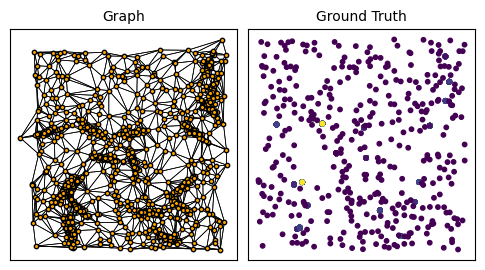

In [60]:
plot_training_data(0)

#### **3. Create Model**

In [61]:
import deeplay as dl

clusterer = dl.MIRO(
    num_outputs=2,
    connectivity_radius=graph_builder.connectivity_radius,
)
clusterer.model.backbone.configure(num_iter=20)
clusterer = clusterer.create()

print(clusterer)

MIRO(
  (model): RecurrentMessagePassingModel(
    (encoder): Parallel(
      (0-1): 2 x MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LinearBlock(
            (layer): LazyLinear(in_features=0, out_features=256, bias=True)
            (activation): Identity()
          )
        )
      )
    )
    (backbone): RecurrentGraphBlock(
      (combine): CatDictElements()
      (layer): Sequential(
        (0): Parallel(
          (0-1): 2 x MultiLayerPerceptron(
            (blocks): LayerList(
              (0): LinearBlock(
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
                (activation): Identity()
              )
            )
          )
        )
        (1): MessagePassingNeuralNetwork(
          (blocks): LayerList(
            (0): TransformPropagateUpdate(
              (transform): Transform(
                (combine): Cat()
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
             

### **4. Train Model**

In [62]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

trainer = dl.Trainer(max_epochs=30) 
trainer.fit(clusterer, train_loader)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                         ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ RecurrentMessagePassingModel │    514 │ train │
│ 1 │ loss          │ L1Loss                       │      0 │ eval  │
│ 2 │ train_metrics │ MetricCollection             │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection             │      0 │ train │
│ 4 │ test_metrics  │ MetricCollection             │      0 │ train │
│ 5 │ optimizer     │ Adam                         │      0 │ train │
└───┴───────────────┴──────────────────────────────┴────────┴───────┘

Trainable params: 514                                                                                              
Non-trainable params: 0                                                                                            
Total params: 514                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 48                                                                                          
Modules in eval mode: 1

Output()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


### **5. Test Model**

In [73]:
val_data = pd.read_csv("data/val_data.csv")

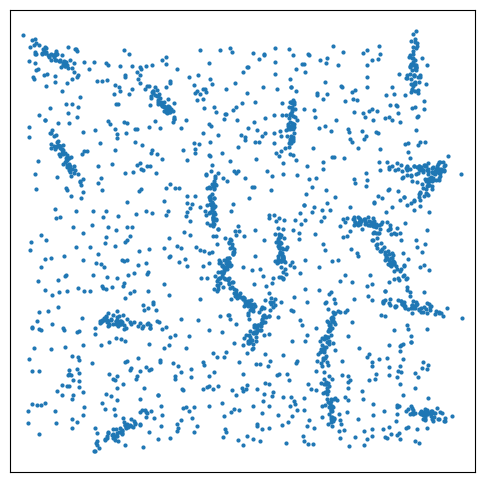

In [74]:
plt.figure(figsize=(6, 6))
plt.scatter(val_data["x"], val_data["y"], s=4)
plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.show()

In [75]:
import torch
from torch_geometric.data import Data

def compute_test_graph(data, graph_builder):
    position = data[["x", "y"]].values
    normalized_position = (position - position.min(axis=0)) / (position.max(axis=0) - position.min(axis=0))

    test_graph = Data(
        position=torch.tensor(normalized_position, dtype=torch.float32),
        num_nodes=position.shape[0]
    )

    test_graph.edge_index, test_graph.edge_attr = graph_builder.compute_connectivity(test_graph.position)
    test_graph = graph_builder.laplacian_embedding(test_graph)

    return test_graph.to("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
val_graph = compute_test_graph(val_data, graph_builder)

In [ ]:
from sklearn.cluster import DBSCAN

clusterer.eval()
clusterer.to("cuda" if torch.cuda.is_available() else "cpu")

clusters = clusterer.clustering(
    val_graph, eps=24, min_samples=10, scaling=val_data[["x", "y"]].max().values
)

In [89]:
from sklearn.cluster import DBSCAN

dbclusters = DBSCAN(eps=30, min_samples=6).fit_predict(val_data[["x", "y"]])

In [90]:
def plot_clustering_results(data, predicted_clusters, db_clusters):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    data_index = data["index"] - 1

    titles = ["DBSCAN", "MIRO + DBSCAN", "Ground Truth"]
    for i, c in enumerate([db_clusters, predicted_clusters, data_index]):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(titles[i], fontsize=10)


        for u in np.unique(c):
            if u == -1:
                ax[i].scatter(
                    data["x"][c == u],
                    data["y"][c == u],
                    s=4,
                    c="gray",
                    alpha=0.5,
                )
            else:
                ax[i].scatter(
                    data["x"][c == u],
                    data["y"][c == u],
                    s=4,
                    c=np.random.rand(3,),
                )


/tmp/ipykernel_7415/804235721.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[i].scatter(


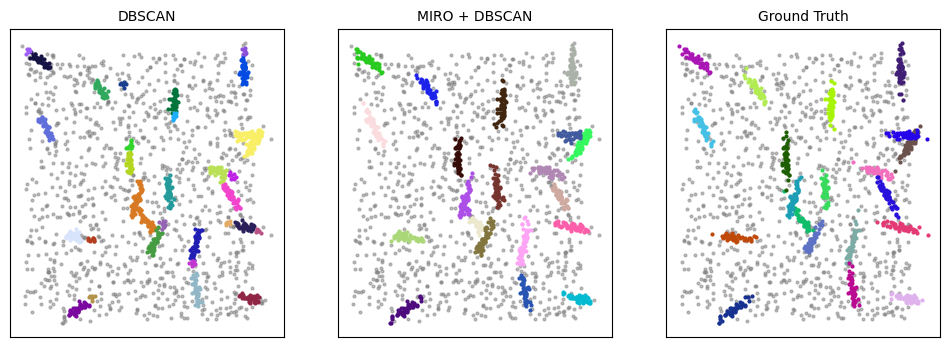

In [91]:
plot_clustering_results(val_data, clusters, dbclusters)